In [8]:
from time import time
import torch
import numpy as np
import pandas as pd
from transformer import SpectraTransformer
t00 = time()


In [9]:
X_fn = './data/X_test.npy'
y_fn = './data/y_test.npy'
X = np.load(X_fn)
y = np.load(y_fn)
print(X.shape, y.shape)


(3000, 1000) (3000,)


In [10]:
# 配置
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
NUM_BINS = 1000      # 光谱长度（适配原始数据）
NUM_CLASSES = 30     # 分类数
print(f"Using device: {DEVICE}")
print(f"CUDA available: {torch.cuda.is_available()}")


Using device: cuda
CUDA available: True


In [11]:
# 创建Transformer模型 - 使用与微调训练时相同的参数
model = SpectraTransformer(
    input_dim=NUM_BINS,
    d_model=128,
    nhead=4,              # 与训练时一致
    num_layers=4,         # 与训练时一致  
    dim_feedforward=512,
    dropout=0.1,
    n_classes=NUM_CLASSES,
    use_cls_token=True
).to(DEVICE)

print(f"Model architecture: {NUM_BINS} input dim, 4 layers, 4 heads")

# 加载微调后的权重
try:
    ckpt = torch.load('./finetuned_transformer_model.ckpt', map_location=DEVICE)
    model.load_state_dict(ckpt)
    print("✓ Loaded fine-tuned transformer model successfully.")
except FileNotFoundError:
    print("⚠ No fine-tuned transformer checkpoint found, trying pretrained...")
    try:
        ckpt = torch.load('./pretrained_transformer_model.ckpt', map_location=DEVICE)
        model.load_state_dict(ckpt, strict=False)
        print("✓ Loaded pretrained transformer model.")
    except FileNotFoundError:
        print("⚠ No transformer checkpoint found, using random initialization.")
except RuntimeError as e:
    print(f"✗ Error loading checkpoint: {e}")
    print("⚠ Proceeding with random initialization.")

model.eval()


Model architecture: 1000 input dim, 4 layers, 4 heads
✓ Loaded fine-tuned transformer model successfully.


c:\Users\Kra\anaconda3\envs\jupyter\Lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


SpectraTransformer(
  (token_embed): Linear(in_features=1, out_features=128, bias=True)
  (pos_encoder): PositionalEncoding()
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (fc): Linear(in_features=128, out_features=30, bias=True)
)

In [12]:
# 数据预处理 - 将数据转换为Transformer期望的格式
# X: (3000, 1000) -> (3000, 1, 1000) 添加通道维度
t0 = time()
x_tensor = torch.from_numpy(X).float().unsqueeze(1).to(DEVICE)
print(f"Input tensor shape: {x_tensor.shape}")

# 批量预测
batch_size = 100
n_samples = len(X)
y_hat = []

with torch.no_grad():
    for i in range(0, n_samples, batch_size):
        end_idx = min(i + batch_size, n_samples)
        batch_x = x_tensor[i:end_idx]
        
        # 前向推理
        logits = model(batch_x)
        probs = torch.softmax(logits, dim=1)
        preds = probs.argmax(dim=1)
        
        y_hat.extend(preds.cpu().numpy())

y_hat = np.array(y_hat)
print('Predicted {} spectra: {:0.2f}s'.format(len(y_hat), time()-t0))


Input tensor shape: torch.Size([3000, 1, 1000])
Predicted 3000 spectra: 1.07s


In [13]:
# Computing accuracy
acc = (y_hat == y).mean()
print('Accuracy: {:0.1f}%'.format(100*acc))


Accuracy: 63.7%


In [14]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from config import ORDER, STRAINS
%matplotlib inline


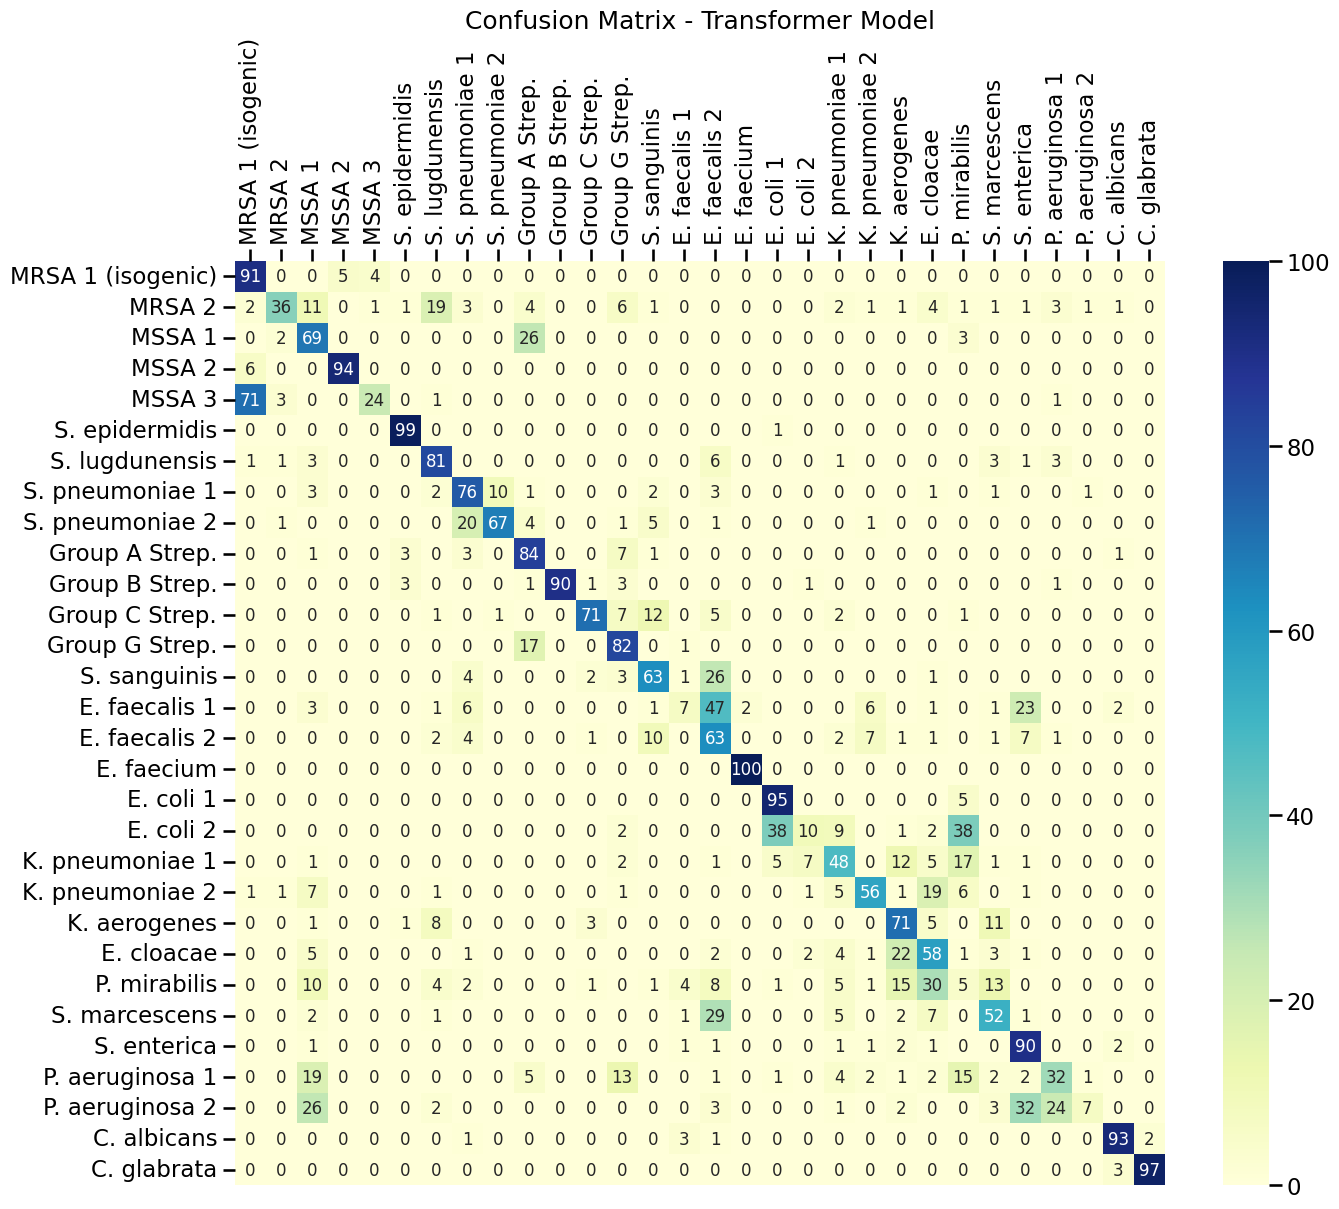

In [15]:
# Plot confusion matrix
sns.set_context("talk", rc={"font":"Helvetica", "font.size":12})
label = [STRAINS[i] for i in ORDER]
cm = confusion_matrix(y, y_hat, labels=ORDER)
plt.figure(figsize=(15, 12))
cm = 100 * cm / cm.sum(axis=1)[:,np.newaxis]
ax = sns.heatmap(cm, annot=True, cmap='YlGnBu', fmt='0.0f',
                 xticklabels=label, yticklabels=label)
ax.xaxis.tick_top()
plt.xticks(rotation=90) 
plt.title('Confusion Matrix - Transformer Model')
plt.show()


In [16]:
from config import ATCC_GROUPINGS, antibiotics, ab_order


In [17]:
# Mapping predictions into antibiotic groupings
y_ab = np.asarray([ATCC_GROUPINGS[i] for i in y])
y_ab_hat = np.asarray([ATCC_GROUPINGS[i] for i in y_hat])

# Computing accuracy
acc = (y_ab_hat == y_ab).mean()
print('Antibiotic grouping accuracy: {:0.1f}%'.format(100*acc))


Antibiotic grouping accuracy: 84.9%


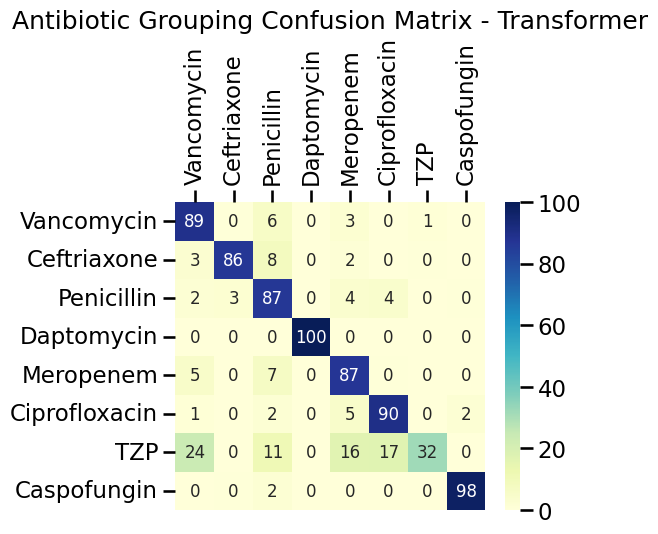


 This demo was completed in: 3.05s


In [18]:
sns.set_context("talk", rc={"font":"Helvetica", "font.size":12})
label = [antibiotics[i] for i in ab_order]
cm = confusion_matrix(y_ab, y_ab_hat, labels=ab_order)
plt.figure(figsize=(5, 4))
cm = 100 * cm / cm.sum(axis=1)[:,np.newaxis]
ax = sns.heatmap(cm, annot=True, cmap='YlGnBu', fmt='0.0f',
                 xticklabels=label, yticklabels=label)
ax.xaxis.tick_top()
plt.xticks(rotation=90) 
plt.title('Antibiotic Grouping Confusion Matrix - Transformer')
plt.show()

print('\n This demo was completed in: {:0.2f}s'.format(time()-t00))


In [19]:
# Optional: Save predictions to file
predictions_df = pd.DataFrame({
    'true_label': y,
    'predicted_label': y_hat,
    'correct': y == y_hat
})

# Save to CSV
predictions_df.to_csv('transformer_reference_predictions.csv', index=False)
print("Predictions saved to transformer_reference_predictions.csv")


Predictions saved to transformer_reference_predictions.csv
